### Imports

In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:80% !important; }</style>'))
%config InlineBackend.figure_format = 'retina'

In [2]:
%cd ..

/home/pinzona/Projects/resume-ner


In [3]:
import os
from collections import OrderedDict, namedtuple
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import flair
import matplotlib.pyplot as plt
import pandas as pd
import torch
from flair.data import Sentence
from flair.embeddings import (DocumentPoolEmbeddings, FlairEmbeddings,
                              WordEmbeddings)
from flair.models import SequenceTagger
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (classification_report, confusion_matrix, f1_score,
                             precision_score, recall_score)

from notebooks.flair_cosine_scorer import CosineSimScorer
from notebooks.test_funcs import test_paths

In [4]:
# if in need set device here
DEVICE_ID = 1
flair.device = torch.device(f'cuda:{DEVICE_ID}')
# flair.device = torch.device('cpu')
print(flair.device)

cuda:1


In [5]:
torch.cuda.is_available()

True

### Paths

In [6]:
SERVER_PATH = Path.cwd().parent
ROOT_PATH = Path.cwd()
print(f'Server path: {SERVER_PATH}')
print(f'Project path: {ROOT_PATH}')

Server path: /home/pinzona/Projects
Project path: /home/pinzona/Projects/resume-ner


In [7]:
# input data 
DATA_DIR_NAME = 'onet-data'
DATA_PATH = ROOT_PATH/DATA_DIR_NAME
ONET_PATH = DATA_PATH/'onet_35_skills.txt'

In [8]:
# resume paths
RESUME_DIR_NAME = 'resume-dataset/set_aside_test-data'
INPUT_FILE_NAMES = ['Set_aside_Indeed_fixed_doccano_v2.json', 'Set_aside_kaggle_v2.json', 'set_aside_kaggle_pt2_v2.json']
RESUME_PATH = SERVER_PATH/RESUME_DIR_NAME
INFILES_PATHS = [RESUME_PATH/fname for fname in INPUT_FILE_NAMES]

In [9]:
ACTUAL_TEST_PATH = DATA_PATH/'TEST_SET_ONET35_MANUALLY_ANNOT_JUAN_v2.csv'

In [10]:
TAGGER_PATH = Path('/home/pinzona/Projects/resume-ner/NER_best_model/resume-ner-ft_true-545cvs-toklimit-v2_4/best-model.pt')

In [11]:
TAG_TYPE = 'ner'

In [12]:
test_paths(dirs=[ROOT_PATH, DATA_PATH], files=[ONET_PATH, ACTUAL_TEST_PATH]+INFILES_PATHS)

### Load Data

In [13]:
onet_df = pd.read_csv(ONET_PATH)
onet_titles = onet_df['ELEMENT NAME'].tolist()

In [14]:
onet_titles

['Reading Comprehension',
 'Active Listening',
 'Writing',
 'Speaking',
 'Mathematics',
 'Science',
 'Critical Thinking',
 'Active Learning',
 'Learning Strategies',
 'Monitoring',
 'Social Perceptiveness',
 'Coordination',
 'Persuasion',
 'Negotiation',
 'Instructing',
 'Service Orientation',
 'Complex Problem Solving',
 'Operations Analysis',
 'Technology Design',
 'Equipment Selection',
 'Installation',
 'Programming',
 'Operation Monitoring',
 'Operation and Control',
 'Equipment Maintenance',
 'Troubleshooting',
 'Repairing',
 'Quality Control Analysis',
 'Judgment and Decision Making',
 'Systems Analysis',
 'Systems Evaluation',
 'Time Management',
 'Management of Financial Resources',
 'Management of Material Resources',
 'Management of Personnel Resources']

In [15]:
dummy = ['business operation']

### Load Scorer

In [16]:
# init Flair forward and backwards embeddings
flair_embedding_forward = FlairEmbeddings('news-forward')
flair_embedding_backward = FlairEmbeddings('news-backward')
glove_embedding = WordEmbeddings('glove')
kamimnos_embedding = WordEmbeddings('extvec')

# create a DocumentPoolEmbedding object that combines glove and forward/backward flair embeddings
document_embeddings_kam = DocumentPoolEmbeddings([
    glove_embedding,
    flair_embedding_forward,
    flair_embedding_backward,
    kamimnos_embedding,
])

In [17]:
# sanity check
scorer = CosineSimScorer(root_path=DATA_PATH, flair_embeedings=document_embeddings_kam,
                         ref_docs=onet_titles)

Process 0th batch


In [18]:
scorer.predict_top_k(dummy, k=len(onet_titles))

Process 0th batch


OrderedDict([('business operation',
              [('Operation and Control', tensor(0.7031, device='cuda:1')),
               ('Operation Monitoring', tensor(0.6657, device='cuda:1')),
               ('Operations Analysis', tensor(0.6514, device='cuda:1')),
               ('Management of Financial Resources',
                tensor(0.6014, device='cuda:1')),
               ('Management of Personnel Resources',
                tensor(0.5834, device='cuda:1')),
               ('Time Management', tensor(0.5753, device='cuda:1')),
               ('Equipment Maintenance', tensor(0.5703, device='cuda:1')),
               ('Management of Material Resources',
                tensor(0.5667, device='cuda:1')),
               ('Technology Design', tensor(0.5485, device='cuda:1')),
               ('Quality Control Analysis', tensor(0.5414, device='cuda:1')),
               ('Service Orientation', tensor(0.5388, device='cuda:1')),
               ('Equipment Selection', tensor(0.5312, device='cuda:1

In [19]:
a = torch.stack([(scorer.sim_matrix > 0.3).type(torch.int).flatten(), (scorer.sim_matrix > 0.3).type(torch.int).flatten()])

In [20]:
a = a.to('cpu')

In [21]:
f1_score(a, a, average='micro')

1.0

In [22]:
precision_score(a, a, average='micro'), recall_score(a, a, average='micro')

(1.0, 1.0)

### Load NERTagger

In [23]:
ner_model = SequenceTagger.load(TAGGER_PATH)

2020-03-19 05:05:25,716 loading file /home/pinzona/Projects/resume-ner/NER_best_model/resume-ner-ft_true-545cvs-toklimit-v2_4/best-model.pt


In [24]:
sents = [Sentence(s, use_tokenizer=True) for s in ["Python Programming, Java", "Complex Problem Solving"]]

In [25]:
result = ner_model.predict(sents)

In [26]:
result[1].to_tagged_string(TAG_TYPE)

'Complex <Soft_Skills> Problem <Soft_Skills> Solving <Soft_Skills>'

### Skill Extraction

In [27]:
def extract_skills(sentences: Union[List[Sentence], Sentence], 
                   tokenize=True) -> Union[List[List[str]], List[str]]:
    """ Extract skills from the predicted by Resume Tagger Model sentence/s

        Args: 
            sentences: NER Tagger prediction
            tokenize: if True return List[List[str]], else List[str], 
            there all tokens joined in one line

        Returns:
            extracted skills from resume/s, if no skills were extracted
            for resume, return specialised token instead
    """
    if isinstance(sentences, Sentence):
        sentences = [sentences]

    ent_types = ['Job_Specific_Skills', 'Soft_Skills', 'Tech_Tools']
    extracted_skills = []

    for sent in sentences:
        prediction_dict = sent.to_dict(tag_type='ner')
        sent_skills = []
        for entity in prediction_dict['entities']:
            if entity['type'] in ent_types:
                sent_skills.append(entity['text'])
        
        if not sent_skills:
            sent_skills.append("__NO__SKILLS__")
        
        if not tokenize:
            sent_skills = [" ".join(sent_skills)]
        extracted_skills.append(sent_skills)

    return extracted_skills

In [28]:
list_of_skills = extract_skills(result, tokenize=False)

In [29]:
list_of_skills

[['Python Programming Java'], ['Complex Problem Solving']]

In [30]:
def get_ngrams(from_sample: List[str], ngram_range: Tuple[int,int]) -> List[str]:
    """ Produce a list of ngram_ranged ngrams from a list of strings.
        
        Args:
            from_sample: sequence of stings
            ngram_range: will produce from N = ngram_range[0] to M = ngram_range[1]
            sequence of ngrams from original input
            
        Returns:
            list of produced ngrams.
            
        Raises:
            ValueError: if from_sample contains an empty string or the length
            of the string is less than the lower bound of ngram_range
    """
    try:
        vect = CountVectorizer(lowercase=False, ngram_range=ngram_range)
        _ = vect.fit_transform(from_sample)
        return vect.get_feature_names()
    except ValueError:
        print("ValueError")
        print(f"empty string or string length is less than lower bound of ngram_range: {ngram_range[0]}")

In [31]:
def ngrams_from_batch(batch: List[List[str]], **kwargs) -> List[List[str]]:
    """ Will produce the secuence of ngrammed documents from the full
        batch of resumes.
    """
    
    return [get_ngrams(from_sample=sample, **kwargs) for sample in batch]

In [32]:
list_of_skills = ngrams_from_batch(list_of_skills, ngram_range=(1,3))

In [33]:
list_of_skills

[['Java',
  'Programming',
  'Programming Java',
  'Python',
  'Python Programming',
  'Python Programming Java'],
 ['Complex',
  'Complex Problem',
  'Complex Problem Solving',
  'Problem',
  'Problem Solving',
  'Solving']]

### Find the Similarity between Onet ref skills and Resume extr skills

In [34]:
# data structure to put actual sentence by sentence similarities (for debug) and similaruty matrix 
SkillsSimilarity = namedtuple('SkillsSimilarity', field_names=['sim_dicts', 'sim_matrix'])

In [35]:
def find_sample_sims(skills: List[str]) -> SkillsSimilarity:
    """ Find similarity scores between N Onet skills and 
        one sample of M extracted resume skills.

        Args:
            skills: M skills extracted from one resume.

        Returns:
            Named tuple with field 'sim_dicts' - closest onet skills
            to extracted resume skill in descendent order and 
            'sim_matrix' - M x N cosine embeeding similarity matrix.
    """

    scores_dict = scorer.predict_top_k(skills)
    sim_matrix = scorer.sim_matrix
    return SkillsSimilarity(scores_dict, sim_matrix)

In [36]:
t = find_sample_sims(list_of_skills[1])

Process 0th batch


In [37]:
t.sim_matrix.shape

torch.Size([6, 35])

In [38]:
t.sim_dicts

OrderedDict([('Complex',
              [('Complex Problem Solving', tensor(0.7044, device='cuda:1')),
               ('Management of Material Resources',
                tensor(0.4819, device='cuda:1')),
               ('Systems Analysis', tensor(0.4620, device='cuda:1')),
               ('Management of Financial Resources',
                tensor(0.4570, device='cuda:1')),
               ('Quality Control Analysis', tensor(0.4553, device='cuda:1'))]),
             ('Complex Problem',
              [('Complex Problem Solving', tensor(0.9158, device='cuda:1')),
               ('Quality Control Analysis', tensor(0.5934, device='cuda:1')),
               ('Management of Material Resources',
                tensor(0.5783, device='cuda:1')),
               ('Systems Analysis', tensor(0.5633, device='cuda:1')),
               ('Critical Thinking', tensor(0.5591, device='cuda:1'))]),
             ('Complex Problem Solving',
              [('Complex Problem Solving', tensor(1., device='cuda:1'

In [39]:
def find_batch_sims(batched_skills: List[List[Optional[str]]]) -> Dict[int, SkillsSimilarity]:
    """ Find similarity scores between N Onet skills and 
        batch of extracted resume skills.

        Args:
            batched_skills: skills extracted from batch of resumes.

        Returns:
            Dictionary with a keys being resume id and 
            values being Named tuples with field 'sim_dicts' 
            - closest onet skills to extracted resume skill in 
            descendent order and 'sim_matrix' - M x N cosine embeeding 
            similarity matrix.
    """

    batch_skills_dict = {}
    for i, sample in enumerate(batched_skills):
        if not sample:
            continue
        batch_skills_dict[i] = find_sample_sims(sample)
    return batch_skills_dict

### Full Linking Pipeline

In [40]:
def jsonl_to_flair_sents(files: List[Union[str, Path]]) -> List[Sentence]:
    """ Convert json lines from json lines file to flair sentences list.

    Args:
        files: list of json lines (like doccano format) filenames.

    Returns:
        A list containing lines from text file converted
        to flair Sentence objects.

    Raises:
        FileNotFoundError: if text filename is not found.
    """

    sents = []
    try:
        for name in files:
            with open(name) as fin:
                sents += [Sentence(json.loads(line)['text']) for line in fin]
        return sents
    except FileNotFoundError:
        raise

In [41]:
def find_skills_sim_from_json(infiles: List[Union[str, Path]] = INFILES_PATHS,
                              use_ngrams: bool = True,
                              ngram_range: Tuple[int,int] = (2,2)) -> Dict[int, SkillsSimilarity]:
    """ Apply functionality of `find_batch_sims` to resumes in the file.

        Args:
            infiles: input filename (jsons for now)
            use_ngrams: if True convert extracted skills token into ngrams,
                        else use unigrams
            ngram_range: ngram range
            
        Returns:
            Dictionary with a keys being resume id and 
            values being Named tuples with field 'sim_dicts' 
            - closest onet skills to extracted resume skill in 
            descendent order and 'sim_matrix' - M x N cosine embeeding 
            similarity matrix.    
    """

    resumes = jsonl_to_flair_sents(files=infiles)
    tagged_resumes = ner_model.predict(resumes)
    tokenize = not use_ngrams
    batched_skills = extract_skills(tagged_resumes, tokenize)
    if use_ngrams:
        batched_skills = ngrams_from_batch(batched_skills, ngram_range=ngram_range)
    return find_batch_sims(batched_skills)

In [42]:
test_sims = find_skills_sim_from_json(ngram_range=(1,3))

Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch
Process 0th batch


In [43]:
len(test_sims)

50

In [44]:
test_sims[1].sim_dicts

OrderedDict([('Accessibility',
              [('Quality Control Analysis', tensor(0.4662, device='cuda:1')),
               ('Service Orientation', tensor(0.4465, device='cuda:1')),
               ('Systems Evaluation', tensor(0.4307, device='cuda:1')),
               ('Equipment Maintenance', tensor(0.4303, device='cuda:1')),
               ('Coordination', tensor(0.4217, device='cuda:1'))]),
             ('Accessibility testing',
              [('Quality Control Analysis', tensor(0.6400, device='cuda:1')),
               ('Systems Evaluation', tensor(0.6318, device='cuda:1')),
               ('Systems Analysis', tensor(0.5796, device='cuda:1')),
               ('Equipment Maintenance', tensor(0.5784, device='cuda:1')),
               ('Equipment Selection', tensor(0.5745, device='cuda:1'))]),
             ('Accessibility testing user',
              [('Systems Evaluation', tensor(0.6505, device='cuda:1')),
               ('Quality Control Analysis', tensor(0.6396, device='cuda:1')),


In [45]:
test_sims[1].sim_matrix.shape

torch.Size([181, 35])

### Get N of resumes x M (35) Onet ref skills OHE matrix

In [46]:
def resumes_sims_to_matr(resumes_sims: Dict[int, SkillsSimilarity]) -> torch.FloatTensor:
    """ Convert the batch of resume to onet ref skills sim matrices
        into N (number of resumes) by M (number of onet skills) matrix
        taking the maximum score for every onet skill.
        
        Args:
            resumes_sims: output of `find_skills_sim_from_json` function
        
        Returns:
            NxM matrix of maximum similarity scores for every resume and every
            Onet reference skill.
    """
    resume_onet_matr = []
    for k in resumes_sims:
        resume_onet_matr.append(resumes_sims[k].sim_matrix.max(dim=0).values)
    resume_onet_matr = torch.stack(resume_onet_matr)
    # make sure it is on cpu
    resume_onet_matr = resume_onet_matr.to('cpu')
    return resume_onet_matr

In [47]:
def threshold(matrix: torch.FloatTensor, th: float) -> torch.IntTensor:
    """ Thresholding the torch float matrix (rank 2)
        
        Args:
            matrix: to threshold
            th: threshold level
        
        Returns:
            OHE matrix
    """
    
    return (matrix > th).type(torch.int)

### Test with human annotation

In [48]:
# load actual test labels
df_test = pd.read_csv(ACTUAL_TEST_PATH)

In [49]:
target_names = df_test.columns[1:].to_list()
len(target_names)

35

In [50]:
test_actuals = df_test.iloc[:, 1:].to_numpy()

In [51]:
test_predictions = resumes_sims_to_matr(test_sims)
test_pred_one = threshold(test_predictions, th=0.6)

In [52]:
f1_score(test_actuals, test_pred_one, average='weighted')

/home/pinzona/.local/share/virtualenvs/resume-ner-dZr2ON7r/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.2759861098593118

In [53]:
precision_score(test_actuals, test_pred_one, average='weighted'), recall_score(test_actuals, test_pred_one, average='weighted')

/home/pinzona/.local/share/virtualenvs/resume-ner-dZr2ON7r/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.3904317023986424, 0.370757180156658)

In [55]:
# 1-3 grams th 0.3 **Best Scores (f1)**
print(classification_report(test_actuals, test_pred_one, target_names=target_names))

                                   precision    recall  f1-score   support

            Reading Comprehension       0.00      0.00      0.00         2
                 Active Listening       1.00      0.20      0.33         5
                          Writing       0.00      0.00      0.00        28
                         Speaking       0.00      0.00      0.00        29
                      Mathematics       0.50      0.20      0.29         5
                          Science       0.00      0.00      0.00         3
                Critical Thinking       0.50      0.29      0.36        14
                  Active Learning       0.11      0.33      0.17         3
              Learning Strategies       0.12      0.50      0.19         6
                       Monitoring       0.33      0.06      0.10        17
            Social Perceptiveness       1.00      0.19      0.32        21
                     Coordination       1.00      0.05      0.10        20
                       P

/home/pinzona/.local/share/virtualenvs/resume-ner-dZr2ON7r/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pinzona/.local/share/virtualenvs/resume-ner-dZr2ON7r/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


## Treshold Anaylisis:

In [89]:
ths = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
precisions = []
recalls = []
for th in ths:
    test_pred_one = threshold(test_predictions, th=th)
    precisions.append(round(precision_score(test_actuals, test_pred_one, average='weighted'), 2))
    recalls.append(round(recall_score(test_actuals, test_pred_one, average='weighted'), 2))

/home/pinzona/.local/share/virtualenvs/resume-ner-dZr2ON7r/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


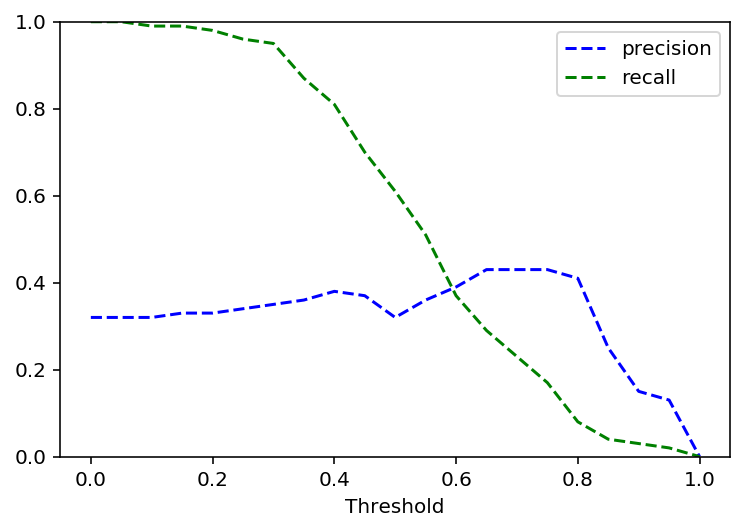

In [90]:
plt.plot(ths, precisions, 'b--', label='precision')
plt.plot(ths, recalls, 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.ylim([0,1])
plt.show()

In [92]:
df = pd.DataFrame(list(zip(ths, precisions, recalls)), 
               columns =['th', 'Precision', 'recall']) 
df
### th = 0.6 seems to be best precision-recall tradeoff 

,th,Precision,recall
0,0.00,0.32,1.00
1,0.05,0.32,1.00
2,0.10,0.32,0.99
3,0.15,0.33,0.99
4,0.20,0.33,0.98
5,0.25,0.34,0.96
6,0.30,0.35,0.95
7,0.35,0.36,0.87
8,0.40,0.38,0.81
9,0.45,0.37,0.70


# SERGEY'S SOLUTION

In [54]:
SERGEY_SKILLS_PRED_FILE = '/home/pinzona/Projects/resume-ner/sergey_out/v14/onet_skills_sergey_pred_v14.csv'
sergey_skills_preds_df = pd.read_csv(SERGEY_SKILLS_PRED_FILE, index_col=False)

In [55]:
sergey_skills_preds_df

,ELEMENT NAME,Indeed_1,Indeed_2,Indeed_3,Indeed_4,Indeed_5,Indeed_6,Indeed_7,Indeed_8,Indeed_9,...,Kaggle_29,Kaggle_30,Kaggle_31,Kaggle_32,Kaggle_33,Kaggle_34,Kaggle_35,Kaggle_36,Kaggle_37,Kaggle_38
0,Reading Comprehension,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Active Listening,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Writing,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Speaking,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Mathematics,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Science,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Critical Thinking,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.676781,0.676781,0.676781,0.676781,0.676781,0.676781,0.676781,0.676781,0.676781,0.676781
7,Active Learning,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.667260,0.667260,0.667260,0.667260,0.667260,0.667260,0.667260,0.667260,0.667260
8,Learning Strategies,0.0,0.000000,0.819061,0.819061,0.819061,0.819061,0.819061,0.819061,0.819061,...,0.819061,0.819061,0.819061,0.819061,0.819061,0.819061,0.819061,0.819061,0.819061,0.819061
9,Monitoring,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [56]:
sergey_preds = sergey_skills_preds_df.T.iloc[1:, :]

In [57]:
# converting df to torch matrix
mtrx = []
for row in range(50):
    row_l = []
    for col in range(35):
        row_l.append(sergey_preds.iloc[row, col])
    mtrx.append(torch.FloatTensor(row_l))

sergey_preds_mtrx = torch.stack(mtrx)
# make sure it is on cpu
sergey_preds_mtrx = sergey_preds_mtrx.to('cpu')

In [58]:
sergey_preds_mtrx.size()

torch.Size([50, 35])

In [59]:
test_pred_one.shape

torch.Size([50, 35])

In [60]:
test_actuals.shape

(50, 35)

In [67]:
# one hot encoding predictions by tresholding
sergey_preds_one = threshold(sergey_preds_mtrx, th=0.55)

In [62]:
f1_score(test_actuals, sergey_preds_one, average='weighted')

/home/pinzona/.local/share/virtualenvs/resume-ner-dZr2ON7r/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.26218841709254115

In [63]:
precision_score(test_actuals, sergey_preds_one, average='weighted'), recall_score(test_actuals, sergey_preds_one, average='weighted')

/home/pinzona/.local/share/virtualenvs/resume-ner-dZr2ON7r/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.20716952846390613, 0.45430809399477806)

## Treshold Anaylisis:

In [64]:
ths = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
precisions = []
recalls = []
f1s = []
for th in ths:
    sergey_preds_one = threshold(sergey_preds_mtrx, th=th)
    precisions.append(round(precision_score(test_actuals, sergey_preds_one, average='weighted'), 2))
    recalls.append(round(recall_score(test_actuals, sergey_preds_one, average='weighted'), 2))
    f1s.append(f1_score(test_actuals, sergey_preds_one, average='weighted'))

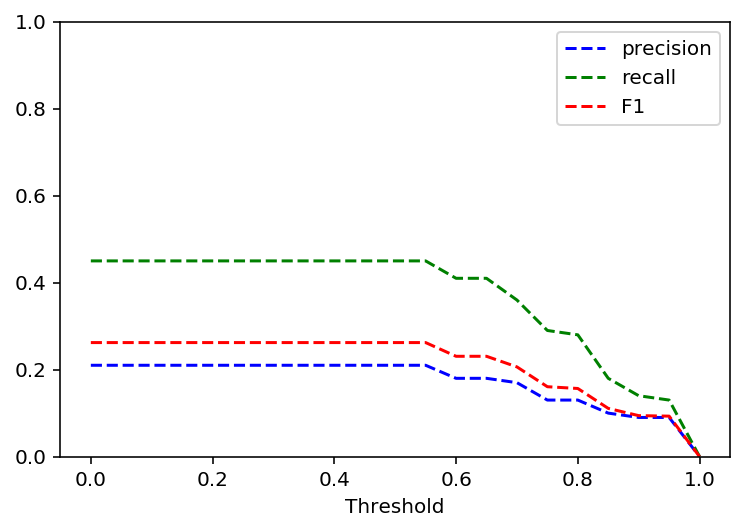

In [65]:
plt.plot(ths, precisions, 'b--', label='precision')
plt.plot(ths, recalls, 'g--', label = 'recall')
plt.plot(ths, f1s, 'r--', label = 'F1')
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.ylim([0,1])
plt.show()

In [66]:
df = pd.DataFrame(list(zip(ths, precisions, recalls, f1s)), 
               columns =['th', 'Precision', 'recall', 'F1']) 
df
### th = 0.5 seems to be best precision-recall tradeoff 

,th,Precision,recall,F1
0,0.00,0.21,0.45,0.262188
1,0.05,0.21,0.45,0.262188
2,0.10,0.21,0.45,0.262188
3,0.15,0.21,0.45,0.262188
4,0.20,0.21,0.45,0.262188
5,0.25,0.21,0.45,0.262188
6,0.30,0.21,0.45,0.262188
7,0.35,0.21,0.45,0.262188
8,0.40,0.21,0.45,0.262188
9,0.45,0.21,0.45,0.262188


## Metrics per ONET Skill:

In [68]:
# th 0.5 **Best Scores (best f1-precision-recall)**
print(classification_report(test_actuals, sergey_preds_one, target_names=target_names))

                                   precision    recall  f1-score   support

            Reading Comprehension       0.00      0.00      0.00         2
                 Active Listening       0.00      0.00      0.00         5
                          Writing       0.59      0.36      0.44        28
                         Speaking       0.00      0.00      0.00        29
                      Mathematics       0.00      0.00      0.00         5
                          Science       0.00      0.00      0.00         3
                Critical Thinking       0.33      0.86      0.48        14
                  Active Learning       0.00      0.00      0.00         3
              Learning Strategies       0.12      1.00      0.22         6
                       Monitoring       0.41      1.00      0.59        17
            Social Perceptiveness       0.00      0.00      0.00        21
                     Coordination       0.00      0.00      0.00        20
                       P

/home/pinzona/.local/share/virtualenvs/resume-ner-dZr2ON7r/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/pinzona/.local/share/virtualenvs/resume-ner-dZr2ON7r/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


# Predictions per CV

In [177]:
cv_ids = ['Indeed_1','Indeed_2','Indeed_3','Indeed_4','Indeed_5','Indeed_6','Indeed_7','Indeed_8','Indeed_9','Indeed_10','Indeed_11','Indeed_12','Kaggle_1','Kaggle_2','Kaggle_3','Kaggle_4','Kaggle_5','Kaggle_6','Kaggle_7',
         'Kaggle_8','Kaggle_9','Kaggle_10','Kaggle_11','Kaggle_12','Kaggle_13','Kaggle_14','Kaggle_15','Kaggle_16','Kaggle_17','Kaggle_18','Kaggle_19','Kaggle_20','Kaggle_21','Kaggle_22','Kaggle_23','Kaggle_24','Kaggle_25',
          'Kaggle_26','Kaggle_27','Kaggle_28','Kaggle_29','Kaggle_30','Kaggle_31','Kaggle_32','Kaggle_33','Kaggle_34','Kaggle_35','Kaggle_36','Kaggle_37','Kaggle_38']
cv_texts = jsonl_to_flair_sents(files=INFILES_PATHS)
cv_counter = 0
print('###### NER - SEMANTIC SIMILARITY PIPELINE TESTING ###### \n')
for cv in test_pred_one:
    tn, fp, fn, tp = confusion_matrix(test_actuals[cv_counter], test_pred_one[cv_counter]).ravel()
    tn2, fp2, fn2, tp2 = confusion_matrix(test_actuals[cv_counter], sergey_preds_one[cv_counter]).ravel()
    tag_counter = 0
    print(cv_ids[cv_counter], ':\n')
    print(cv_texts[cv_counter])
    print('\n### PREDICTED ONET SKILLS: ###\n')
    for pred in test_pred_one[cv_counter]:
        gold = test_actuals[cv_counter][tag_counter]
        if pred > 0 or gold >0 or int(sergey_preds_one[cv_counter][tag_counter]) > 0:
            #print(target_names[tag_counter], ':', int(pred)) 
            print(target_names[tag_counter], '-> NER Pipe Pred:', int(pred), '-- Sergey/Roman Pred: ', int(sergey_preds_one[cv_counter][tag_counter]), '-- GROUND TRUTH:', int(gold))     
        tag_counter += 1
    print('\n#### NER PIPELINE STATISTICS ####     #### SERGEY/ROMAN STATISTICS ####')
    print('## FP: ',fp, ' TP: ',tp, '  Precision:', round(precision_score(test_actuals[cv_counter], test_pred_one[cv_counter], average='binary'), 2), 
         '   ## FP:', fp2, ' TP: ', tp2, '  Precision:', round(precision_score(test_actuals[cv_counter], sergey_preds_one[cv_counter], average='binary'), 2)) 
    print('## FN: ',fn, ' TN: ', tn, '  Recall:', round(recall_score(test_actuals[cv_counter], test_pred_one[cv_counter], average='binary'), 2),
         '     ## FN: ', fn2, ' TN: ', tn2, '  Recall:', round(recall_score(test_actuals[cv_counter], sergey_preds_one[cv_counter], average='binary'), 2)) 
    cv_counter = cv_counter + 1
    print('\n########################################################################\n')

###### NER - SEMANTIC SIMILARITY PIPELINE TESTING ###### 

Indeed_1 :

Sentence: "Govardhana K
Senior Software Engineer

Bengaluru, Karnataka, Karnataka - Email me on Indeed: indeed.com/r/Govardhana-K/
b2de315d95905b68

Total IT experience 5 Years 6 Months
Cloud Lending Solutions INC 4 Month • Salesforce Developer
Oracle 5 Years 2 Month • Core Java Developer
Languages Core Java, Go Lang
Oracle PL-SQL programming,
Sales Force Developer with APEX.

Designations & Promotions

Willing to relocate: Anywhere

WORK EXPERIENCE

Senior Software Engineer

Cloud Lending Solutions - Bangalore, Karnataka -

January 2018 to Present

Present

Senior Consultant

Oracle - Bangalore, Karnataka -

November 2016 to December 2017

Staff Consultant

Oracle - Bangalore, Karnataka -

January 2014 to October 2016

Associate Consultant

Oracle - Bangalore, Karnataka -

November 2012 to December 2013

EDUCATION

B.E in Computer Science Engineering

Adithya Institute of Technology - Tamil Nadu

September 2008 to 

Equipment Maintenance -> NER Pipe Pred: 1 -- Sergey/Roman Pred:  0 -- GROUND TRUTH: 0
Quality Control Analysis -> NER Pipe Pred: 1 -- Sergey/Roman Pred:  0 -- GROUND TRUTH: 0
Judgment and Decision Making -> NER Pipe Pred: 1 -- Sergey/Roman Pred:  0 -- GROUND TRUTH: 0
Systems Analysis -> NER Pipe Pred: 1 -- Sergey/Roman Pred:  0 -- GROUND TRUTH: 0
Systems Evaluation -> NER Pipe Pred: 1 -- Sergey/Roman Pred:  0 -- GROUND TRUTH: 0
Time Management -> NER Pipe Pred: 1 -- Sergey/Roman Pred:  0 -- GROUND TRUTH: 0
Management of Financial Resources -> NER Pipe Pred: 1 -- Sergey/Roman Pred:  0 -- GROUND TRUTH: 0
Management of Material Resources -> NER Pipe Pred: 1 -- Sergey/Roman Pred:  0 -- GROUND TRUTH: 0
Management of Personnel Resources -> NER Pipe Pred: 1 -- Sergey/Roman Pred:  0 -- GROUND TRUTH: 1

#### NER PIPELINE STATISTICS ####     #### SERGEY/ROMAN STATISTICS ####
## FP:  15  TP:  4   Precision: 0.21    ## FP: 0  TP:  0   Precision: 0.0
## FN:  5  TN:  11   Recall: 0.44      ## FN:  9

## FN:  8  TN:  18   Recall: 0.11      ## FN:  9  TN:  26   Recall: 0.0

########################################################################

Kaggle_29 :

Sentence: ""www.uaehrzone.com CURRICULUM VITAE Mr. Stephan B.E.(CIVIL) Company Name DUBAI - U.A.E. Tel: +971 50 500000 Email : feedback@uaehrzone.com Profession : Civil Engineer Nationality : British Date of Birth : 10.05.1975 Qualification : Bachelor of Civil Engineering ( B.E. civil ) TAFE, Australia 1988 Additional Qualification : Graduate Diploma in Project Management ( GDPM ) National Institute of Construction Management and Research, UK 2003 OSHA training course Certified by U.S.Department of Labour.,2007 Computer Proficiency : MS Office ,Primavera P3 Marital Status : Married Languages Known : English, Arbaic, German Key Experience : Driving licence : Total 19 years in management and execution in construction and finishes of residential projects, high rise Buildings, commercial complexes & industrial projects (U.A.E. 13 ye